# cluster the cryo healthy scans (32,42,43) and the  dead scans (73,82)
April 5, 2022



In [2]:
import beamtime_config_2022
from beamtime_config_2022 import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib import rc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import seaborn as sns

import xrf_roif_2022

from xrf_roif_2022 import *

import xrfm_batches
from xrfm_batches import *

import fuzzy_kmeans_engine
from fuzzy_kmeans_engine import _format_soft_km_axes, soft_clustering_weights

from sklearn import metrics


%matplotlib inline

# define parameters

In [3]:
BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '/data02/AZC/March_2022_XRF_Data/'


# coarse_scan_names = ['bnp_fly0032.mda.h5']


coarse_scan_names = ['bnp_fly0032.mda.h5', 
                    'bnp_fly0042.mda.h5',
                    'bnp_fly0043.mda.h5',
                    'bnp_fly0073.mda.h5',
                    'bnp_fly0082.mda.h5']



hdf5_string_list=['MAPS','MAPS','MAPS','MAPS','MAPS']
norm_ch_list=['US_IC','US_IC','US_IC','US_IC','US_IC']
selected_elm_maps_list=[selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps]
noise_type_list = [noise_type,noise_type,noise_type,noise_type,noise_type]

# bin_conv_elm_list=['P', 'P', 'P', 'P', 'P']
bin_conv_elm_list=['KPSCa', 'KPSCa', 'KPSCa', 'KPSCa', 'KPSCa']
# bin_conv_elm_list=['TFY', 'TFY', 'TFY', 'TFY', 'TFY']

apply_gaussian_list=[False, False, False, False,False]
value_offset_list = [1e-12,1e-12,1e-12,1e-12,1e-12]


# assemble coarse scans

In [4]:
coarse_scans = XRFM_batch(base_file_path,
                  coarse_scan_names,
                 hdf5_string_list,
                 norm_ch_list,
                 selected_elm_maps_list,
                 noise_type_list,
                 bin_conv_elm_list,
                 value_offset_list,
                apply_gaussian_list,
                 BASE_PATCH_WIDTH,
                 print_pv=False,  
                 verbosity=False)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
print('Total extracted cells, features:', coarse_scans.X.shape)
print('Total extracted cell, cell size:', coarse_scans.X_bin.shape)


XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0032.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(41, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0042.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(36, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0043.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(17, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0073.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(19, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0082.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(11, 14)
Bounding box width and height (pixels): 32
Total extracted cells, features: (124, 14)
Total extracted cell, cell size: (124, 32, 32)


/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:106: RuntimeWarning: divide by zero encountered in true_divide
  xrfdata[e].append(xrf[chidx]/norm)
/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:106: RuntimeWarning: invalid value encountered in true_divide
  xrfdata[e].append(xrf[chidx]/norm)


(321, 321)
(321, 321)
(149, 321)
(321, 321)
(118, 321)


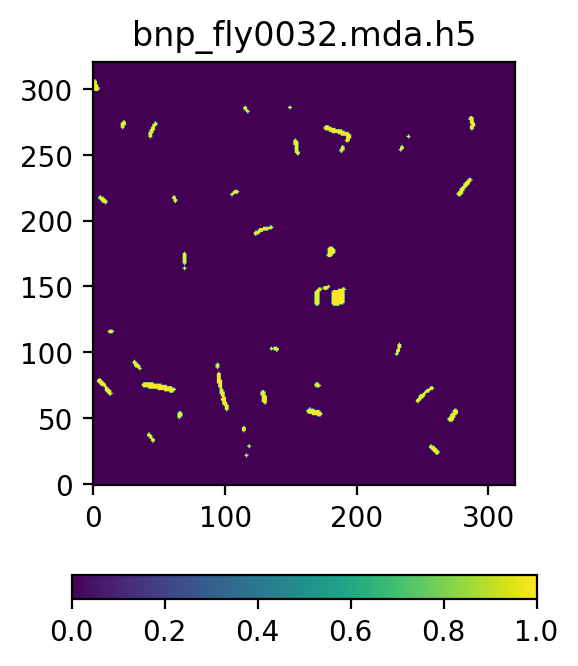

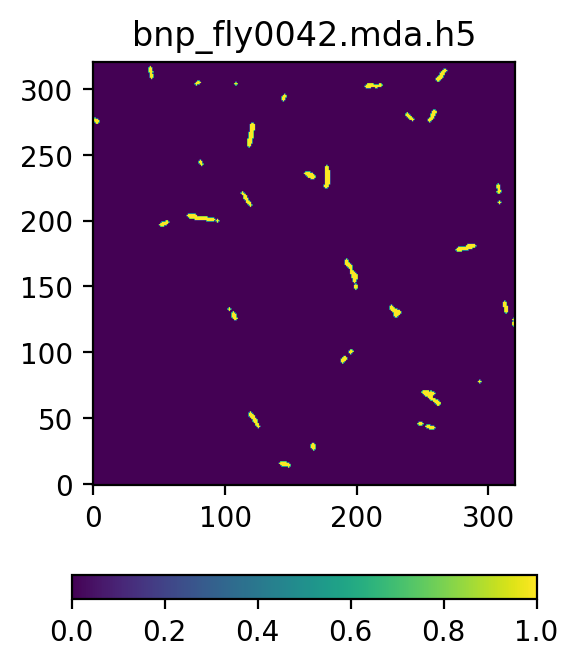

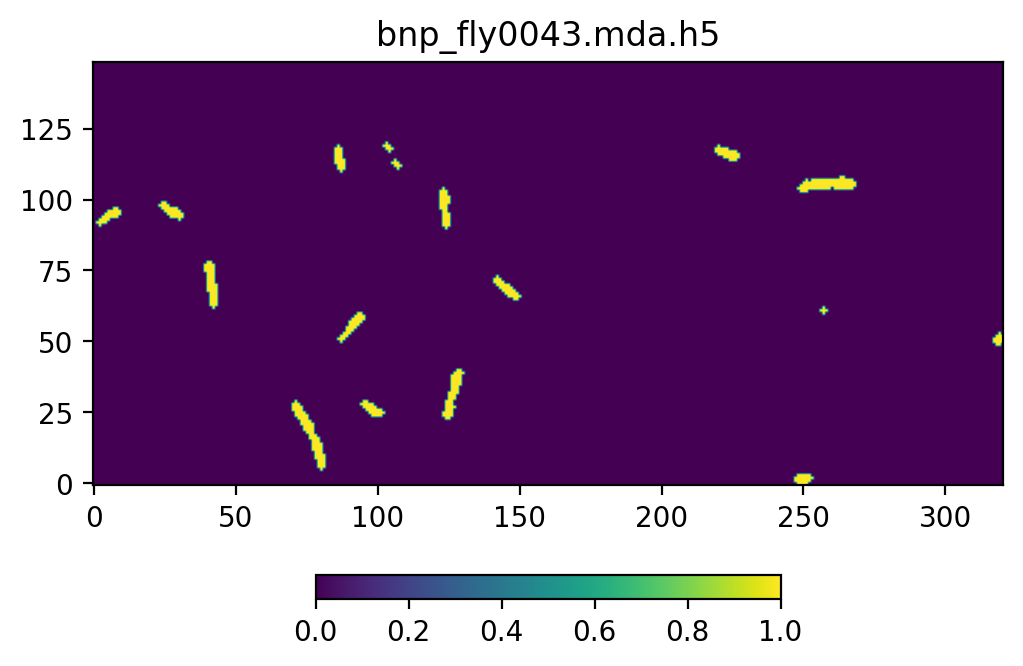

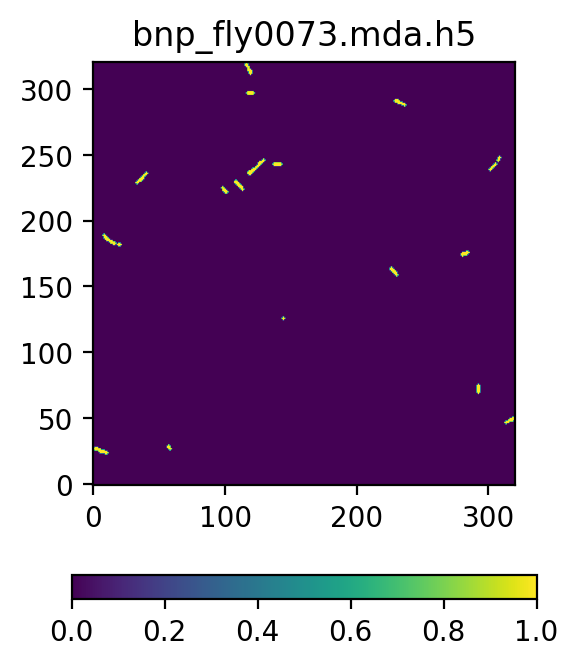

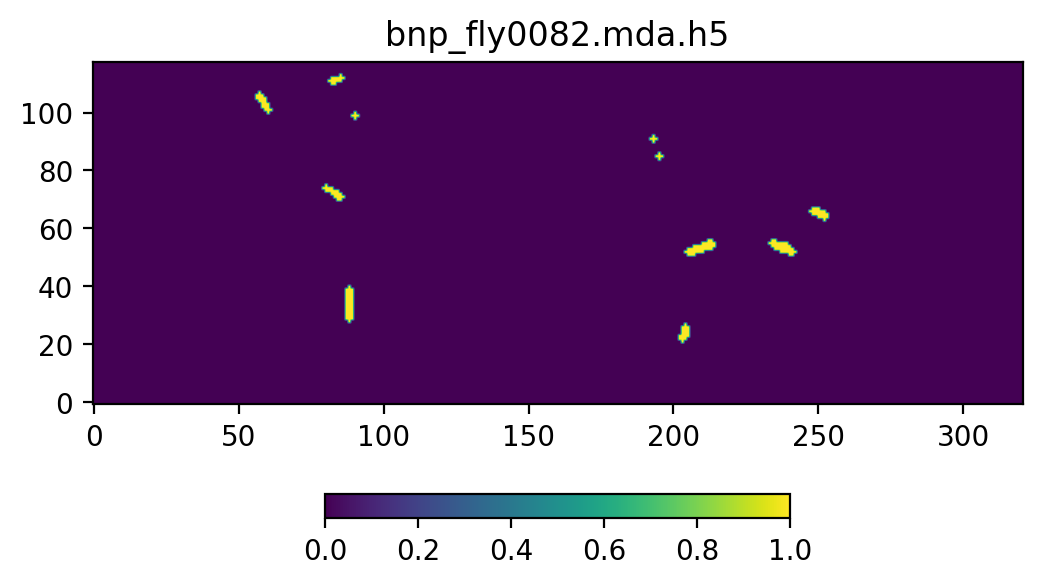

In [5]:
coarse_scans.plot_coarse_binary_images()

# construct dataframe with all the extracted information from defined features
inside the beamtime_XRF_image_extract_cell_method

In [6]:
principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])


principalDf['area'] = coarse_scans.X[:,0]
principalDf['eccentricity'] = coarse_scans.X[:,1]
principalDf['equivalent_diameter'] = coarse_scans.X[:,2]
principalDf['major_axis_length'] = coarse_scans.X[:,3]
principalDf['minor_axis_length'] = coarse_scans.X[:,4]
principalDf['perimeter'] = coarse_scans.X[:,5]
principalDf['K'] = coarse_scans.X[:,6]
principalDf['P'] = coarse_scans.X[:,7]
principalDf['Ca'] = coarse_scans.X[:,8]
principalDf['Zn'] = coarse_scans.X[:,9]
principalDf['Fe'] = coarse_scans.X[:,10]
principalDf['Cu'] = coarse_scans.X[:,11]
principalDf['BFY'] = coarse_scans.X[:,12]
principalDf['Pixel_count'] = coarse_scans.X[:,13].astype(int)   #Pixel_count column must exist

#add res and origins to dataframe here
#convert from list
principalDf['x_res'] = coarse_scans.X_x_res
principalDf['y_res'] = coarse_scans.X_y_res
principalDf['avg_res'] = coarse_scans.X_avg_res
principalDf['x_origin'] = coarse_scans.X_x_origin
principalDf['y_origin'] = coarse_scans.X_y_origin
principalDf['x_motor'] = coarse_scans.X_x_motor
principalDf['y_motor'] = coarse_scans.X_y_motor
principalDf['xrf_file']=coarse_scans.X_xrf_track_files




#assign scan names in dataframe
number_of_cells = principalDf['xrf_file'].to_numpy().shape[0]
coarse_scan_name=[]
for idx in range(number_of_cells):

    coarse_scan_name.append(os.path.split(principalDf['xrf_file'].to_numpy()[idx])[1])
principalDf['scan_name'] =  np.array(coarse_scan_name)  


display(principalDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name
0,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000042,0.000038,0.000047,...,0.007212,0.25,0.256287,0.253143,110.674377,-661.065186,139.674377,-655.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
1,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
2,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000036,0.000046,0.000051,...,0.007115,0.25,0.256287,0.253143,110.674377,-661.065186,140.174377,-653.815186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
3,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
4,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,0.007210,0.25,0.256287,0.253143,110.674377,-661.065186,139.174377,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000017,0.000139,0.000079,...,0.002593,0.25,0.245728,0.247864,-73.469749,-1059.976318,-24.719749,-1038.726318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5
120,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000024,0.000138,0.000091,...,0.002823,0.25,0.245728,0.247864,-73.469749,-1059.976318,-25.219749,-1037.226318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5
121,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000009,0.000054,0.000065,...,0.002072,0.25,0.245728,0.247864,-73.469749,-1059.976318,-50.969749,-1035.226318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5
122,21,1.3125,0.941908,1.292721,2.248000,0.755036,4.181981,0.000017,0.000119,0.000056,...,0.001975,0.25,0.245728,0.247864,-73.469749,-1059.976318,-58.969749,-1034.226318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5


# remove extracted cells that contain less than certain amount of pixels

In [7]:
secondaryDf=remove_artifacts(principalDf, remove_count = 8)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

# secondaryDf.head()

/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['original index'] = secondaryDf.index.to_numpy()


,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,Zn,Fe,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name,original index
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,0.000071,0.000048,0.000072,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,0.000051,0.000035,0.000046,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,0.000053,0.000040,0.000037,0.007210,0.25,0.256287,0.253143,110.674377,-661.065186,139.174377,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,0.000055,0.000042,0.000059,0.007298,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,5
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,0.000070,0.000044,0.000052,0.007146,0.25,0.256287,0.253143,110.674377,-661.065186,126.924377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,6
5,49,3.0625,0.925859,1.974664,3.245418,1.226342,7.035534,0.000044,0.000089,0.000127,0.000077,0.000041,0.000051,0.007242,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,7
6,95,5.9375,0.993093,2.749520,8.450952,0.991554,15.906854,0.000055,0.000079,0.000064,0.000049,0.000051,0.000058,0.007374,0.25,0.256287,0.253143,110.674377,-661.065186,134.924377,-643.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,8
7,38,2.3750,0.927087,1.738949,2.844144,1.066118,5.974874,0.000055,0.000073,0.000113,0.000045,0.000046,0.000046,0.007229,0.25,0.256287,0.253143,110.674377,-661.065186,142.924377,-644.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,9
8,47,2.9375,0.984730,1.933944,4.921048,0.856704,7.303301,0.000050,0.000099,0.000051,0.000058,0.000039,0.000058,0.007299,0.25,0.256287,0.253143,110.674377,-661.065186,173.174377,-644.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,10
9,50,3.1250,0.977717,1.994711,4.549151,0.955001,8.010408,0.000050,0.000064,0.000114,0.000078,0.000044,0.000051,0.007258,0.25,0.256287,0.253143,110.674377,-661.065186,112.674377,-642.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,11


# view the location of a cell on main XRF image
must be in matplotlib inline mode

In [8]:
coarse_scans.ROI_viewer(selected_elm_channel = 'P', linethresh_val=0.00001)


interactive(children=(IntSlider(value=61, description='idx', max=123), Output()), _dom_classes=('widget-intera…

# view all extracted cells if all elements are analyzed.

In [9]:
linethresh_val=0.00001
# resolution=DEFAULT_RESOLUTION_CELL

%matplotlib inline

def viewer(idx):    
    
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(coarse_scans.X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*coarse_scans.X_x_res[idx], "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    ax2.invert_yaxis()
    im2 = ax2.imshow(coarse_scans.X_Cu[idx], interpolation='none')
#     im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.invert_yaxis()


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    ax3.invert_yaxis()
    im3 = ax3.imshow(coarse_scans.X_Zn[idx], interpolation='none')
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');
    ax3.invert_yaxis()

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    ax4.invert_yaxis()
    im4 = ax4.imshow(coarse_scans.X_Ca[idx], interpolation='none', vmax=0.000035)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');
    ax4.invert_yaxis()


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    ax5.invert_yaxis()
    im5 = ax5.imshow(coarse_scans.X_K[idx], interpolation='none')
#     im5 = ax5.imshow(X_K[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');
    ax5.invert_yaxis()

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    ax6.invert_yaxis()
    im6 = ax6.imshow(coarse_scans.X_P[idx], interpolation='none')
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');
    ax6.invert_yaxis()

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    ax7.invert_yaxis()
    im7 = ax7.imshow(coarse_scans.X_S[idx], interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');
    ax7.invert_yaxis()

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    ax8.invert_yaxis()
    im8 = ax8.imshow(coarse_scans.X_Ni[idx], interpolation='none')
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');
    ax8.invert_yaxis()

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    ax9.invert_yaxis()
    im9 = ax9.imshow(coarse_scans.X_Fe[idx], interpolation='none')
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');
    ax9.invert_yaxis()

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    ax10.invert_yaxis()
    im10 = ax10.imshow(coarse_scans.X_TFY[idx], interpolation='none')
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    ax10.invert_yaxis()
    
    print('Avg. Cu:',np.average(coarse_scans.X_Cu[idx]))
    print('Avg. Zn:',np.average(coarse_scans.X_Zn[idx]))
    print('Avg. Ca:',np.average(coarse_scans.X_Ca[idx]))
    print('Avg. K:',np.average(coarse_scans.X_K[idx]))
    print('Avg. P:',np.average(coarse_scans.X_P[idx]))
    print('Avg. S:',np.average(coarse_scans.X_S[idx]))
    print('Avg. Fe:',np.average(coarse_scans.X_Fe[idx]))
    print('Avg. Ni:',np.average(coarse_scans.X_Ni[idx]))
    print('Avg. TFY:',np.average(coarse_scans.X_TFY[idx]))
    
    print('Max. Cu:',np.max(coarse_scans.X_Cu[idx]))
    print('Max. Zn:',np.max(coarse_scans.X_Zn[idx]))
    print('Max. Ca:',np.max(coarse_scans.X_Ca[idx]))
    print('Max. K:',np.max(coarse_scans.X_K[idx]))
    print('Max. P:',np.max(coarse_scans.X_P[idx]))
    print('Max. S:',np.max(coarse_scans.X_S[idx]))
    print('Max. Fe:',np.max(coarse_scans.X_Fe[idx]))
    print('Max. Ni:',np.max(coarse_scans.X_Ni[idx]))
    print('Max. TFY:',np.max(coarse_scans.X_TFY[idx]))
    

    
    

interactive_plot = interactive(viewer, idx=(0, len(coarse_scans.X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot



interactive(children=(IntSlider(value=61, description='idx', max=123), Output()), _dom_classes=('widget-intera…

# Construct the features for PCA

In [10]:
# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe'],
#     secondaryDf['Cu'],secondaryDf['BFY']
#                ]).T

# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
#                ]).T


mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
               ]).T

print('Cells, features', mod_X.shape)

Cells, features (106, 7)


# perform PCA

PC = f('area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ca','Zn',
         'Fe')
         

Cells, PCs (106, 2)
singular_values_: [14.95508058 12.83315463]
explained_variance: [2.13004224 1.56847484]
components: [[ 0.28432613  0.41563912 -0.21150339  0.44361483  0.55675397  0.44079471
   0.02449505]
 [ 0.3784722   0.18879809  0.63311783 -0.42938884  0.10842451  0.15190484
   0.44840847]]


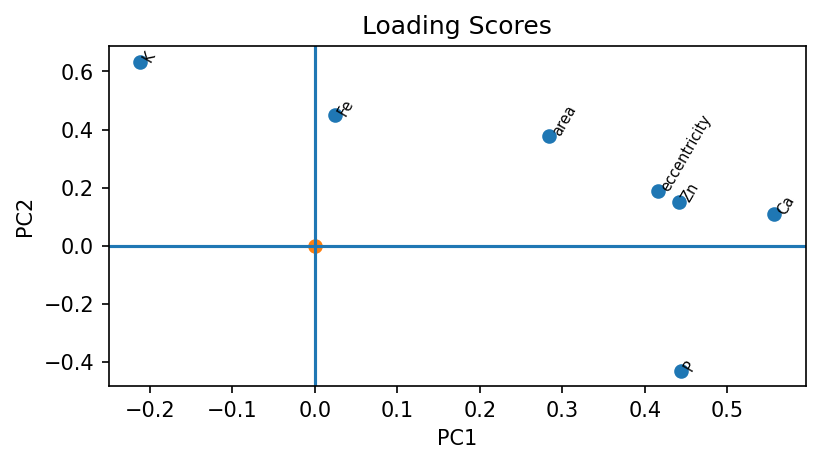

<Figure size 432x288 with 0 Axes>

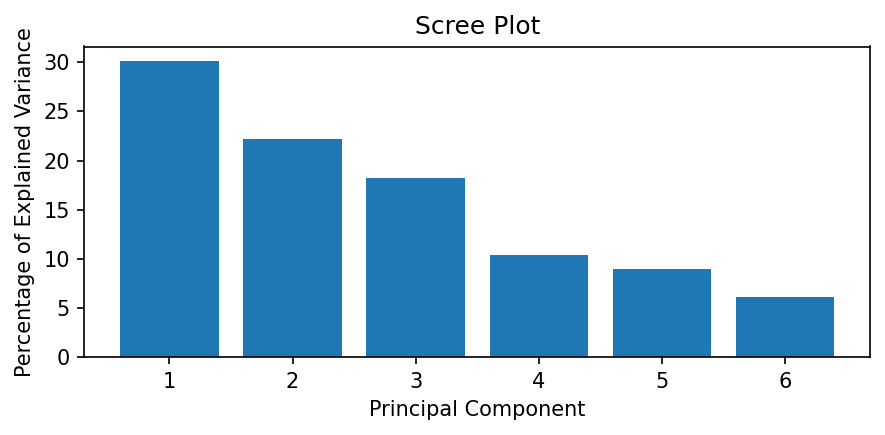

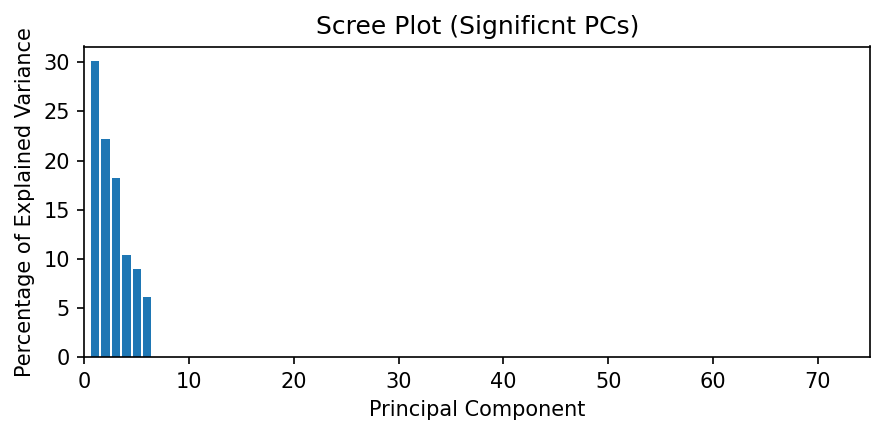

/tmp/ipykernel_13326/4082877442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC1']=principalComponents[:,0]
/tmp/ipykernel_13326/4082877442.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC2']=principalComponents[:,1]


IndexError: index 2 is out of bounds for axis 1 with size 2

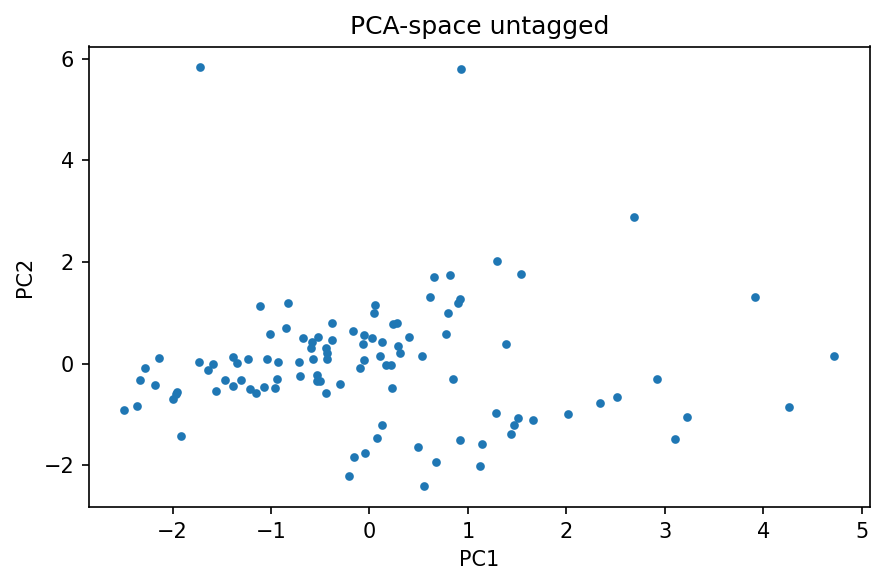

In [11]:
%matplotlib inline

# feature_names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
#         'K','P','Ca','Zn',
#          'Fe']

feature_names = ['area','eccentricity','K','P','Ca','Zn','Fe']


principalComponents, loading_scores = XRF_PCA(mod_X, feature_names, high_comp=6, n_components=2, 
                                              annot_txt_size=7, dpi =150, marker_size=3,save_plots=True)

#assign PC values to dataframe
secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]
secondaryDf['PC3']=principalComponents[:,2]



In [ ]:
# feature_list = ["area", "eccentricity","K","P"]
feature_list = ["area", "eccentricity", "K"]
# feature_list = ["K","P"]
# PC_names=["PC1", "PC2","PC3"]
PC_names=["PC1", "PC2"]

    
view_PC_feature_relation(secondaryDf,PC_names, feature_list, hue = 'scan_name',save_plots=True )

In [12]:
secondaryDf.head()

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name,original index,PC1,PC2
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1,0.166639,-0.033176
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3,-1.116131,1.140094
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,0.253143,110.674377,-661.065186,139.174377,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4,-2.334037,-0.332396
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,...,0.253143,110.674377,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,5,0.131042,0.433937
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,...,0.253143,110.674377,-661.065186,126.924377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,6,-0.939156,-0.295826


In [13]:
# import plotly.express as px
fig = px.scatter_3d(secondaryDf, x='PC1', y='PC2', z='PC3', symbol='scan_name', size_max=5,
              color='eccentricity',size='area')

fig.update_traces(marker_size = 4)
fig.update_coloraxes(colorbar_orientation='h')
fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    )
fig.show()
fig.write_image('../figures/PCA_eccentricity_3D.jpg')


ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of ['Pixel_count', 'area', 'eccentricity', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'perimeter', 'K', 'P', 'Ca', 'Zn', 'Fe', 'Cu', 'BFY', 'x_res', 'y_res', 'avg_res', 'x_origin', 'y_origin', 'x_motor', 'y_motor', 'xrf_file', 'scan_name', 'original index', 'PC1', 'PC2'] but received: PC3

# tag based off of experiments, so we can see the effect of sample prep.

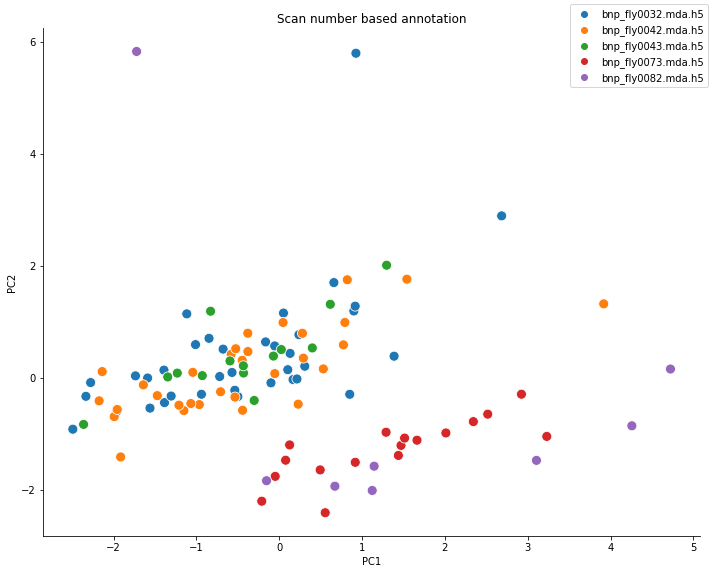

In [14]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='scan_name', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Scan number based annotation')
plt.tight_layout()
plt.savefig('../figures/pc_space_scan_tagged.jpg')

In [15]:
print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))  

\begin{tabular}{lrrrrrrr}
\toprule
{} &    area &  eccentricity &         K &         P &        Ca &        Zn &        Fe \\
\midrule
0   &  1.9375 &      0.926864 &  0.000042 &  0.000085 &  0.000074 &  0.000071 &  0.000048 \\
1   &  1.3125 &      0.945323 &  0.000069 &  0.000055 &  0.000065 &  0.000051 &  0.000035 \\
2   &  0.6875 &      0.755929 &  0.000046 &  0.000057 &  0.000034 &  0.000053 &  0.000040 \\
3   &  2.6250 &      0.926738 &  0.000054 &  0.000088 &  0.000078 &  0.000055 &  0.000042 \\
4   &  1.1250 &      0.722659 &  0.000042 &  0.000064 &  0.000100 &  0.000070 &  0.000044 \\
5   &  3.0625 &      0.925859 &  0.000044 &  0.000089 &  0.000127 &  0.000077 &  0.000041 \\
6   &  5.9375 &      0.993093 &  0.000055 &  0.000079 &  0.000064 &  0.000049 &  0.000051 \\
7   &  2.3750 &      0.927087 &  0.000055 &  0.000073 &  0.000113 &  0.000045 &  0.000046 \\
8   &  2.9375 &      0.984730 &  0.000050 &  0.000099 &  0.000051 &  0.000058 &  0.000039 \\
9   &  3.1250 &      0.9777

/tmp/ipykernel_13326/2506169708.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))


Length true list:  81
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dict_keys(['False', 'True'])


/tmp/ipykernel_13326/3348611444.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = text_labels


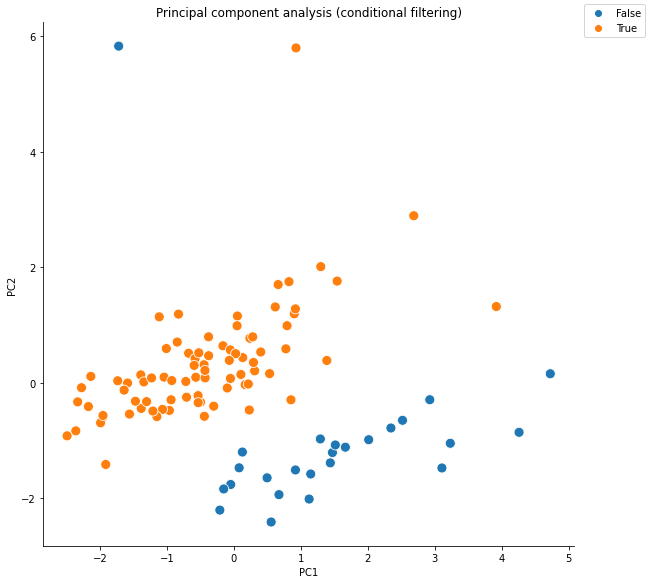

In [16]:
# condition check

labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)


y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = False
    if text_labels[idx] ==1:
        text_labels[idx] = True
        
secondaryDf['text_labels'] = text_labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



In [18]:
y_dh

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
secondaryDf['y_dh']=y_dh.astype(int)

/tmp/ipykernel_13326/587906483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['y_dh']=y_dh.astype(int)


In [108]:
# keep 25 constant type B cell vary type A cells

type_B_Df=secondaryDf[secondaryDf['y_dh']==0]
type_A_Df=secondaryDf[secondaryDf['y_dh']==1]

# sample 25 Type A cells 

pick_values = [6,9,13,17,25,38,50]
# pick_values = np.linspace(1,50,50)
# pick_values = pick_values.astype(int)
rand_index_list = []
adj_rand_index_list = []
dice_score_list = []

for val in pick_values:

    sampled_Type_A_Df=type_A_Df.sample(n=val, replace=False, random_state=0)

    sampled_Df=sampled_Type_A_Df
    sampled_Df =pd.concat([sampled_Type_A_Df, type_B_Df], axis = 0)

    sampled_Df.reset_index(drop=True, inplace=True)



    kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(sampled_Df[['PC1','PC2']].to_numpy())
    inertia=kmeans.inertia_
    sampled_Df['Class'] = kmeans.labels_


    rand_index=metrics.rand_score(sampled_Df['y_dh'].to_numpy(), kmeans.labels_)
    rand_index_list.append(rand_index)
#     print('unadjusted rand index [0,1]:',rand_index)
    adj_rand_index=metrics.adjusted_rand_score(sampled_Df['y_dh'].to_numpy(), kmeans.labels_)
#     print('adjusted rand index [-1,1]:',adj_rand_index)
    adj_rand_index_list.append(adj_rand_index)
    
    dice_score = dice(sampled_Df['Class'].to_numpy(), sampled_Df['y_dh'].to_numpy(), k = 1) 
#     print ("Dice Similarity: {}".format(dice_score))
    dice_score_list.append(dice_score)




In [109]:
# fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=130)
# fig.suptitle('K-means clustering performance')
# # ax[0].scatter(pick_values/25,rand_index_list, s=5)
# ax[0].scatter( np.array(pick_values)/25,rand_index_list, s=5)
# ax[0].set_xlabel('Type A/Type B Imbalance ratio')
# ax[0].set_ylabel('Rand Index')
# # ax[1].scatter(pick_values/25,adj_rand_index_list, s=5)
# ax[1].scatter( np.array(pick_values)/25,adj_rand_index_list, s=5)
# ax[1].set_xlabel('Type A/Type B Imbalance ratio')
# ax[1].set_ylabel('Adjusted Rand Index')


Text(0, 0.5, 'Dice Score')

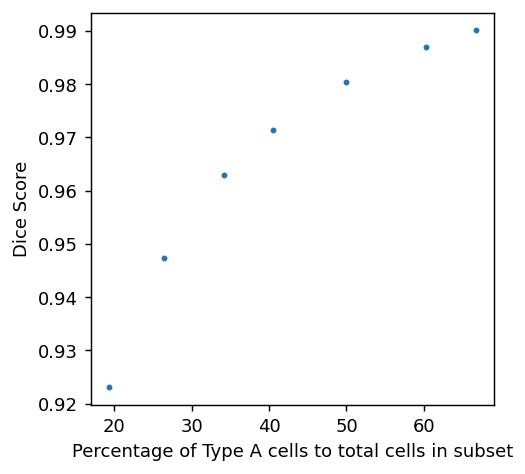

In [111]:

plt.figure(figsize=(4,4), dpi=130)
# plt.scatter(pick_values/25,dice_score_list, s=5)
plt.scatter( 100*np.array(pick_values)/(np.array(pick_values)+25),dice_score_list, s=5)
plt.xlabel('Percentage of Type A cells to total cells in subset')
plt.ylabel('Dice Score')


In [112]:
# keep 25 constant type A cell vary type B cells
type_B_Df=secondaryDf[secondaryDf['y_dh']==0]
type_A_Df=secondaryDf[secondaryDf['y_dh']==1]

# sample 25 Type A cells 

pick_values = [2,4,6,8,10,12,14,16,18,20]
# pick_values = np.linspace(1,50,50)
# pick_values = pick_values.astype(int)
rand_index_list = []
adj_rand_index_list = []
dice_score_list = []

for val in pick_values:
    sampled_Type_A_Df=type_A_Df.sample(n=25, replace=False, random_state=0)
    sampled_Type_B_Df=type_B_Df.sample(n=val, replace=False, random_state=0)

#     sampled_Df=sampled_Type_A_Df
    sampled_Df =pd.concat([sampled_Type_A_Df, sampled_Type_B_Df], axis = 0)

    sampled_Df.reset_index(drop=True, inplace=True)



    kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(sampled_Df[['PC1','PC2']].to_numpy())
    inertia=kmeans.inertia_
    sampled_Df['Class'] = kmeans.labels_


    rand_index=metrics.rand_score(sampled_Df['y_dh'].to_numpy(), kmeans.labels_)
    rand_index_list.append(rand_index)
#     print('unadjusted rand index [0,1]:',rand_index)
    adj_rand_index=metrics.adjusted_rand_score(sampled_Df['y_dh'].to_numpy(), kmeans.labels_)
#     print('adjusted rand index [-1,1]:',adj_rand_index)
    adj_rand_index_list.append(adj_rand_index)
    
    dice_score = dice(sampled_Df['Class'].to_numpy(), sampled_Df['y_dh'].to_numpy(), k = 1) 
#     print ("Dice Similarity: {}".format(dice_score))
    dice_score_list.append(dice_score)




Text(0, 0.5, 'Dice Score')

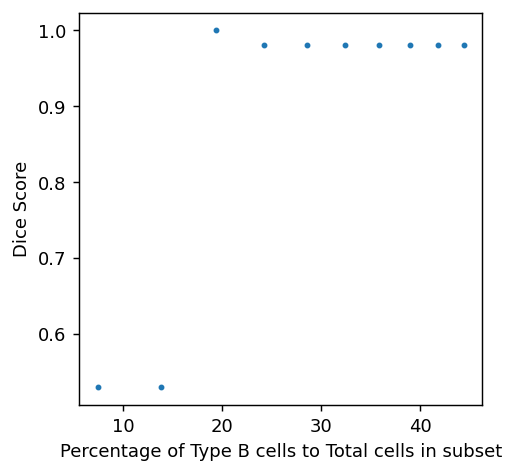

In [113]:

plt.figure(figsize=(4,4), dpi=130)
# plt.scatter(pick_values/25,dice_score_list, s=5)
plt.scatter( 100*np.array(pick_values)/(np.array(pick_values)+25),dice_score_list, s=5)
plt.xlabel('Percentage of Type B cells to Total cells in subset')
plt.ylabel('Dice Score')


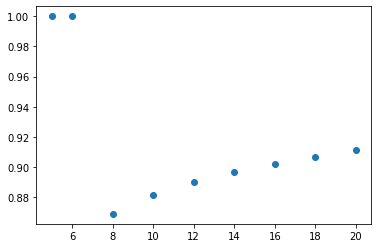

In [105]:
plt.scatter(pick_values,adj_rand_index_list)

In [1]:
import cv2

# Dice similarity function
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

# dice_score = dice(y_pred, y_true, k = 255) #k =255 or 1 or other target values
# print ("Dice Similarity: {}".format(dice_score))

In [65]:
type_B_Df=secondaryDf[secondaryDf['y_dh']==0]
type_A_Df=secondaryDf[secondaryDf['y_dh']==1]

# sample 25 Type A cells 
balance_ratios=[0.4, 0.8,  1, 1.2]
pick_values = [10]
# pick_values = np.linspace(1,81,81)
# pick_values = pick_values.astype(int)
dice_score_list_4_type_A = []

for val in pick_values:
    
    for balance_ratio in balance_ratios:
        sampled_Type_A_Df=type_A_Df.sample(n=val, replace=False, random_state=0)
#         print( math.ceil(balance_ratio*val) )
        total_cells=val + math.ceil(balance_ratio*val)
        pct_total_cells = 100*total_cells/81
        print(pct_total_cells)
    
        sampled_Type_B_Df=type_B_Df.sample(n=math.ceil(balance_ratio*val), replace=False, random_state=0)


        sampled_Df =pd.concat([sampled_Type_A_Df, sampled_Type_B_Df], axis = 0)
    
        sampled_Df.reset_index(drop=True, inplace=True)



        kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(sampled_Df[['PC1','PC2']].to_numpy())
        inertia=kmeans.inertia_
        sampled_Df['Class'] = kmeans.labels_


        dice_score = dice(sampled_Df['Class'].to_numpy(), sampled_Df['y_dh'].to_numpy(), k = 1) 
        print ("Dice Similarity: {}".format(dice_score))
        dice_score_list_4_type_A.append(dice_score)




17.28395061728395
Dice Similarity: 0.0
22.22222222222222
Dice Similarity: 0.0
24.691358024691358
Dice Similarity: 0.9523809523809523
27.160493827160494
Dice Similarity: 0.0


In [52]:
type_B_Df=secondaryDf[secondaryDf['y_dh']==0]
type_A_Df=secondaryDf[secondaryDf['y_dh']==1]

# sample 25 Type A cells 
balance_ratios=[0.5, 1, 1.5]
pick_values = [4]
# pick_values = np.linspace(1,81,81)
# pick_values = pick_values.astype(int)
dice_score_list_4_type_A = []

for val in pick_values:
    
    for balance_ratio in balance_ratios:
        sampled_Type_A_Df=type_A_Df.sample(n=val, replace=False, random_state=0)
#         print( math.ceil(balance_ratio*val) )
        total_cells=val + math.ceil(balance_ratio*val)
        pct_total_cells = 100*total_cells/81
        print(pct_total_cells)
    
        sampled_Type_B_Df=type_B_Df.sample(n=math.ceil(balance_ratio*val), replace=False, random_state=0)


        sampled_Df =pd.concat([sampled_Type_A_Df, sampled_Type_B_Df], axis = 0)
    
        sampled_Df.reset_index(drop=True, inplace=True)



        kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(sampled_Df[['PC1','PC2']].to_numpy())
        inertia=kmeans.inertia_
        sampled_Df['Class'] = kmeans.labels_


        dice_score = dice(sampled_Df['Class'].to_numpy(), sampled_Df['y_dh'].to_numpy(), k = 1) 
    #     print ("Dice Similarity: {}".format(dice_score))
        dice_score_list_4_type_A.append(dice_score)




7.407407407407407
9.876543209876543
12.345679012345679


In [53]:
dice_score_list_4_type_A

[1.0, 1.0, 1.0]

In [61]:
type_B_Df=secondaryDf[secondaryDf['y_dh']==0]
type_A_Df=secondaryDf[secondaryDf['y_dh']==1]

# sample 25 Type A cells 
balance_ratios=[0.5, 1, 1.5]
pick_values = [8]
# pick_values = np.linspace(1,81,81)
# pick_values = pick_values.astype(int)
dice_score_list_8_type_A = []

for val in pick_values:
    
    for balance_ratio in balance_ratios:
        sampled_Type_A_Df=type_A_Df.sample(n=val, replace=False, random_state=0)
#         print( math.ceil(balance_ratio*val) )
        total_cells=val + math.ceil(balance_ratio*val)
        pct_total_cells = 100*total_cells/81
        print(pct_total_cells)
    
        sampled_Type_B_Df=type_B_Df.sample(n=math.ceil(balance_ratio*val), replace=False, random_state=0)


        sampled_Df =pd.concat([sampled_Type_A_Df, sampled_Type_B_Df], axis = 0)
    
        sampled_Df.reset_index(drop=True, inplace=True)



        kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(sampled_Df[['PC1','PC2']].to_numpy())
        inertia=kmeans.inertia_
        sampled_Df['Class'] = kmeans.labels_


        dice_score = dice(sampled_Df['Class'].to_numpy(), sampled_Df['y_dh'].to_numpy(), k = 1) 
    #     print ("Dice Similarity: {}".format(dice_score))
        dice_score_list_8_type_A.append(dice_score)




14.814814814814815
19.753086419753085
24.691358024691358


In [62]:
dice_score_list_8_type_A

[0.6666666666666666, 0.2222222222222222, 0.2222222222222222]

In [60]:
type_B_Df=secondaryDf[secondaryDf['y_dh']==0]
type_A_Df=secondaryDf[secondaryDf['y_dh']==1]

# sample 25 Type A cells 
balance_ratios=[0.5, 1, 1.5]
pick_values = [12]
# pick_values = np.linspace(1,81,81)
# pick_values = pick_values.astype(int)
dice_score_list_12_type_A = []

for val in pick_values:
    
    for balance_ratio in balance_ratios:
        sampled_Type_A_Df=type_A_Df.sample(n=val, replace=False, random_state=0)
#         print( math.ceil(balance_ratio*val) )
        total_cells=val + math.ceil(balance_ratio*val)
        pct_total_cells = 100*total_cells/81
        print(pct_total_cells)
    
        sampled_Type_B_Df=type_B_Df.sample(n=math.ceil(balance_ratio*val), replace=False, random_state=0)


        sampled_Df =pd.concat([sampled_Type_A_Df, sampled_Type_B_Df], axis = 0)
    
        sampled_Df.reset_index(drop=True, inplace=True)



        kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(sampled_Df[['PC1','PC2']].to_numpy())
        inertia=kmeans.inertia_
        sampled_Df['Class'] = kmeans.labels_
        
#         pp = sns.pairplot(data=sampled_Df,
#                   y_vars=['PC2'],
#                   x_vars=['PC1'],
#                   kind = 'scatter', 
#                  diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
#                  )
#         leg_handles = pp._legend_data.values()
#         leg_labels = pp._legend_data.keys()
#         pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
#         pp._legend.remove() # remove existing legend
#         pp.set(xlabel='PC1',
#                ylabel='PC2',
#                title='10% sampled data')

#         plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
#         plt.tight_layout()



        dice_score = dice(sampled_Df['Class'].to_numpy(), sampled_Df['y_dh'].to_numpy(), k = 1) 
        print ("Dice Similarity: {}".format(dice_score))
        dice_score_list_12_type_A.append(dice_score)




22.22222222222222
Dice Similarity: 0.6666666666666666
29.62962962962963
Dice Similarity: 0.9565217391304348
37.03703703703704
Dice Similarity: 1.1724137931034482


In [57]:
dice_score_list_12_type_A

[0.0, 0.0, 0.0]

In [20]:


kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
secondaryDf['Class'] = kmeans.labels_


/tmp/ipykernel_13326/4034018373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['Class'] = kmeans.labels_


Dice Similarity: 0.9685534591194969


In [24]:
frac_values = np.linspace(0.1,1,20)
rand_index_list = []
adj_rand_index_list = []
for idx, val in enumerate(frac_values):
    

    secondaryDf_temp=

    kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf_temp[['PC1','PC2']].to_numpy())
    inertia=kmeans.inertia_
    secondaryDf_temp['Class'] = kmeans.labels_


    rand_index=metrics.rand_score(secondaryDf_temp['y_dh'].to_numpy(), kmeans.labels_)
    rand_index_list.append(rand_index)
    print('unadjusted rand index [0,1]:',rand_index)
    adj_rand_index=metrics.adjusted_rand_score(secondaryDf_temp['y_dh'].to_numpy(), kmeans.labels_)
    print('adjusted rand index [-1,1]:',adj_rand_index)
    adj_rand_index_list.append(adj_rand_index)


unadjusted rand index [0,1]: 0.8181818181818182
adjusted rand index [-1,1]: 0.6357615894039735
unadjusted rand index [0,1]: 0.875
adjusted rand index [-1,1]: 0.7457627118644068
unadjusted rand index [0,1]: 0.6190476190476191
adjusted rand index [-1,1]: 0.24568965517241378
unadjusted rand index [0,1]: 0.9230769230769231
adjusted rand index [-1,1]: 0.8163634308961465
unadjusted rand index [0,1]: 0.9354838709677419
adjusted rand index [-1,1]: 0.8310933527061387
unadjusted rand index [0,1]: 0.6777777777777778
adjusted rand index [-1,1]: 0.3184652278177458
unadjusted rand index [0,1]: 0.6780487804878049
adjusted rand index [-1,1]: 0.3242939546033411
unadjusted rand index [0,1]: 0.523671497584541
adjusted rand index [-1,1]: 0.05638866235041526
unadjusted rand index [0,1]: 0.5341176470588235
adjusted rand index [-1,1]: 0.07311992715666213
unadjusted rand index [0,1]: 0.5227272727272727
adjusted rand index [-1,1]: 0.0532121694732651
unadjusted rand index [0,1]: 0.5224043715846994
adjusted rand

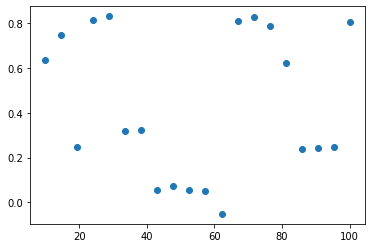

In [28]:
plt.scatter(100*frac_values,adj_rand_index_list)

# perform k-means on 10% randomly sampled data

inertia:  26.206990812724353
unadjusted rand index [0,1]: 0.8181818181818182
adjusted rand index [-1,1]: 0.6357615894039735


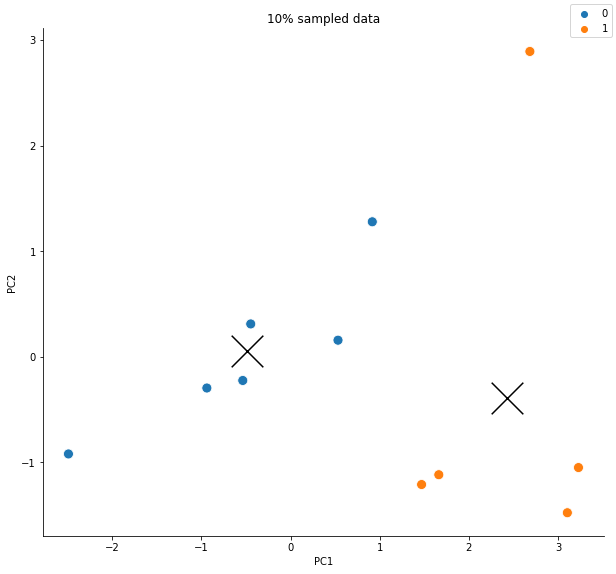

In [17]:

secondaryDf_10=secondaryDf.sample(frac=0.1, replace=False, random_state=42)

kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf_10[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf_10['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf_10,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='10% sampled data')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered_10.jpg')


rand_index=metrics.rand_score(secondaryDf_10['y_dh'].to_numpy(), kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(secondaryDf_10['y_dh'].to_numpy(), kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)



inertia:  35.168739615727
unadjusted rand index [0,1]: 0.6190476190476191
adjusted rand index [-1,1]: 0.24568965517241378


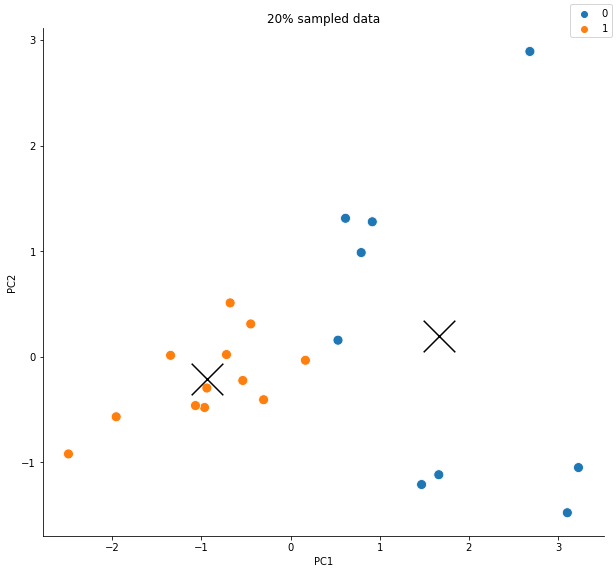

In [51]:
secondaryDf_20=secondaryDf.sample(frac=0.2, replace=False, random_state=42)

kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf_20[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf_20['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf_20,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='20% sampled data')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered_20.jpg')

rand_index=metrics.rand_score(secondaryDf_20['y_dh'].to_numpy(), kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(secondaryDf_20['y_dh'].to_numpy(), kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)



inertia:  72.74127911565661
unadjusted rand index [0,1]: 0.5428156748911466
adjusted rand index [-1,1]: 0.09179736538171836


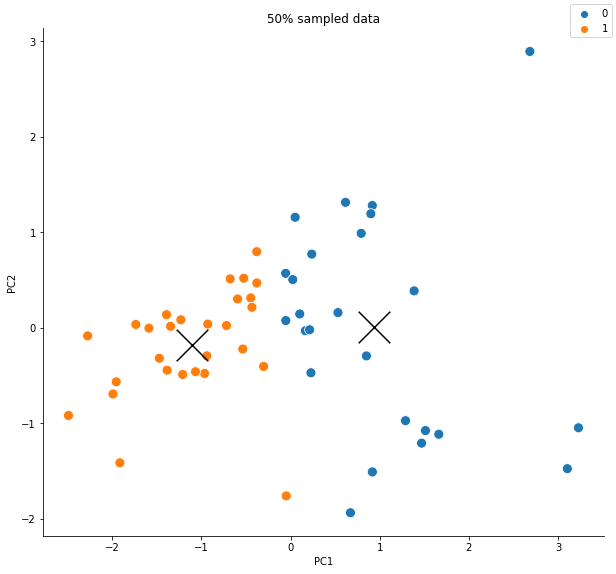

In [52]:
secondaryDf_50=secondaryDf.sample(frac=0.5, replace=False, random_state=42)

kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf_50[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf_50['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf_50,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='50% sampled data')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered_50.jpg')

rand_index=metrics.rand_score(secondaryDf_50['y_dh'].to_numpy(), kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(secondaryDf_50['y_dh'].to_numpy(), kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)



inertia:  250.1344317388474
unadjusted rand index [0,1]: 0.9092542677448338
adjusted rand index [-1,1]: 0.8072199773835504


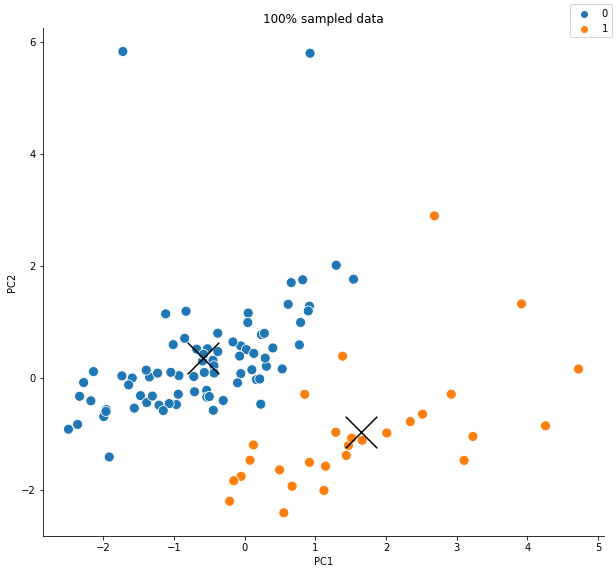

In [53]:
secondaryDf_100=secondaryDf.sample(frac=1.0, replace=False, random_state=42)

kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf_100[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf_100['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf_100,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='100% sampled data')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered_100.jpg')

rand_index=metrics.rand_score(secondaryDf_100['y_dh'].to_numpy(), kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(secondaryDf_100['y_dh'].to_numpy(), kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)





# apply scan based filter to annotate ideal cluster



Length true list:  81
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_3527/3348611444.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = text_labels


dict_keys(['False', 'True'])


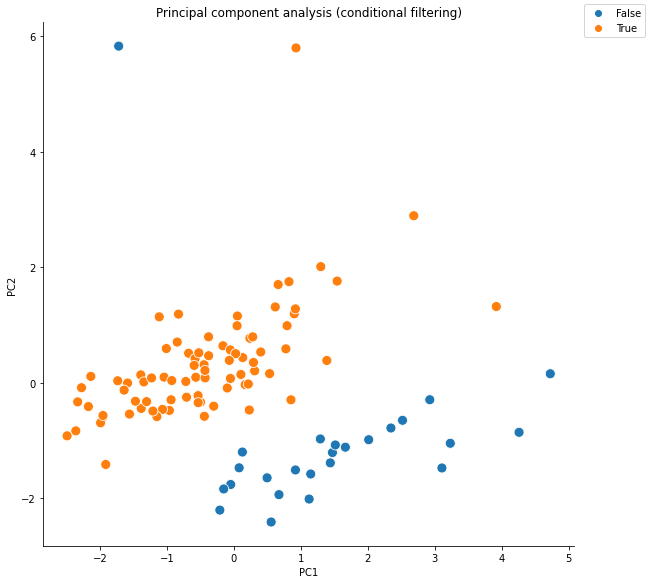

In [18]:
# condition check

labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)


y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = False
    if text_labels[idx] ==1:
        text_labels[idx] = True
        
secondaryDf['text_labels'] = text_labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



# fuzzy k-means (currently works for 2 PCs)

In [20]:
df=secondaryDf

In [21]:
df

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,y_origin,x_motor,y_motor,xrf_file,scan_name,original index,PC1,PC2,Class,text_labels
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1,0.166639,-0.033176,1,True
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3,-1.116131,1.140094,1,True
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,-661.065186,139.174377,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4,-2.334037,-0.332396,1,True
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,...,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,5,0.131042,0.433937,1,True
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,...,-661.065186,126.924377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,6,-0.939156,-0.295826,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,31,1.9375,0.930962,1.570637,2.610152,0.953011,5.535534,0.000022,0.000129,0.000147,...,-1059.976318,-14.219749,-1046.726318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5,116,4.257249,-0.859209,0,False
102,20,1.2500,0.886135,1.261566,1.858871,0.861452,3.974874,0.000013,0.000118,0.000083,...,-1059.976318,-10.969749,-1043.726318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5,117,1.122454,-2.014436,0,False
103,20,1.2500,0.948433,1.261566,2.289306,0.725656,4.078427,0.000017,0.000107,0.000079,...,-1059.976318,-52.969749,-1041.976318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5,118,1.145811,-1.580795,0,False
104,21,1.3125,0.941908,1.292721,2.248000,0.755036,4.181981,0.000017,0.000119,0.000056,...,-1059.976318,-58.969749,-1034.226318,/data02/AZC/March_2022_XRF_Data/bnp_fly0082.md...,bnp_fly0082.mda.h5,122,0.671847,-1.938220,0,False


In [22]:
#for 2 PCs
for i in range(3):
    df['p' + str(i)] = 0
    
# df[['p0', 'p1']] = soft_clustering_weights(X, kmeans.cluster_centers_)
df[['p0', 'p1']] = soft_clustering_weights(principalComponents, kmeans.cluster_centers_)
df['confidence'] = np.max(df[['p0', 'p1']].values, axis = 1)

/tmp/ipykernel_3527/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p' + str(i)] = 0
/tmp/ipykernel_3527/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p' + str(i)] = 0
/tmp/ipykernel_3527/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [23]:
df['confidence']

0      0.947668
1      0.994363
2      0.955474
3      0.984775
4      0.994402
         ...   
101    0.930067
102    0.974564
103    0.991366
104    0.928316
105    0.607374
Name: confidence, Length: 106, dtype: float64

In [24]:
np.unique(df['Class'].to_numpy())

array([0, 1], dtype=int32)

In [25]:
labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()       
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)
y_dh=np.array(labels).astype(int)

df['y']=y_dh
df['labels']=y_dh

Length true list:  81
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_3527/3048668556.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y']=y_dh
/tmp/ipykernel_3527/3048668556.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels']=y_dh


In [26]:
df['labels']

0      1
1      1
2      1
3      1
4      1
      ..
101    0
102    0
103    0
104    0
105    0
Name: labels, Length: 106, dtype: int64

In [27]:
# Make sure colours are the same for the actual class and the kmeans class in the plots.
# Count the most frequent species that appears in each class
df_color_converter = df.groupby('Class', as_index = False)['labels'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'labels']
    
    

In [28]:
len(y_dh)

106

In [29]:
y_dh

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


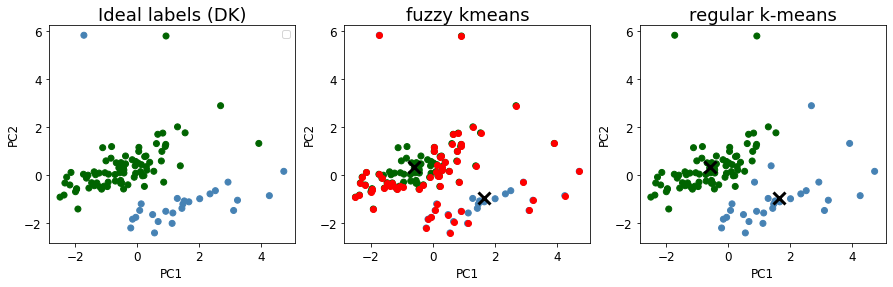

In [30]:
colors = [ 'steelblue', 'darkgreen']

fig, axs = plt.subplots(1, 3, figsize = (15,4))

ax = _format_soft_km_axes(axs[0])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Ideal labels (DK)', pad = 5, fontsize = 18)
ax.legend()
plt.savefig('../figures/FCKM_ideal_labels.jpg')

# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

# ax.plot(
#     kmeans.cluster_centers_[:,-2],
#     kmeans.cluster_centers_[:,-1],
#     'xk',
#     markersize = 15,
#     markeredgewidth = 3
# )

ax = _format_soft_km_axes(axs[1])

confidence_threshold=0.99 #0.9 default

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.scatter(
    df.loc[df['confidence'] < confidence_threshold, 'PC1'],
    df.loc[df['confidence'] < confidence_threshold, 'PC2'],
#     color = df.loc[df['confidence'] > confidence_threshold, 'Class'].apply(lambda x: colors[color_converter_dict[x]])
    color = ['red']
)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('fuzzy kmeans', pad = 5, fontsize = 18)




ax = _format_soft_km_axes(axs[2])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in kmeans.labels_]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('regular k-means', pad = 5, fontsize = 18)


# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

plt.savefig('../figures/FCKM.jpg')


In [38]:
#calculated clustering performance metrics

from sklearn import metrics

rand_index=metrics.rand_score(y_dh, kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(y_dh, kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)



unadjusted rand index [0,1]: 0.9449832481043907
adjusted rand index [-1,1]: 0.8765751672321408


In [39]:
secondaryDf['x_res']

0      0.25
1      0.25
2      0.25
3      0.25
4      0.25
       ... 
102    0.25
103    0.25
104    0.25
105    0.25
106    0.25
Name: x_res, Length: 107, dtype: float32

# apply a simple condition to filter the data

In [ ]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']>=secondaryDf['K'].median()) &
    (secondaryDf['K']/secondaryDf['P']>=(secondaryDf['K']/secondaryDf['P']).median())
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 

y_dh=labels    #domain h labels
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = False
    if labels[idx] ==1:
        labels[idx] = True
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



In [ ]:
# # look for outliers if exist
# secondaryDf[secondaryDf['PC2']>8]

In [ ]:
# # check if the filtering true false labels are correct

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

# secondaryDf['original index']

# view distribution of features for the two kmeans classes

In [ ]:
select_feature_channel = 'K'

secondaryDf[secondaryDf['Class']==0][select_feature_channel]
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(ax=ax[0],data=secondaryDf[secondaryDf['Class']==0], x=select_feature_channel, kde=True,color='blue')
ax[0].set_title('k-means (class = 0)')

sns.histplot(ax=ax[1],data=secondaryDf[secondaryDf['Class']==1], x=select_feature_channel, kde=True,color='orange')
ax[1].set_title('k-means (class = 1)')

# view the last xrf files extracted cells on the PC plot marked with orange

In [ ]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[(secondaryDf['xrf_file']==current_xrf_filename)].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'previous XRF measurement'
    if labels[idx] ==1:
        labels[idx] = 'current measurement'
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis  (current measurement))')



In [ ]:
%matplotlib notebook

subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

# pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000,c=secondaryDf.Class, facecolors='black')
pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy(), c=secondaryDf.Class,
                 cmap='winter')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*pts.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend)

selector = SelectFromCollection(ax, pts)

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("LIVE-DEAD Cell clusters\n Press enter to accept selected points. Select one point to view main XRF image")

plt.show()



In [ ]:
#shows selected indices in secondaryDf

print('number of selected cells:', len(selector.ind))

print('modified_indices:', selector.ind)

#conversions to original indices
target_scan_cell_indices = secondaryDf['original index'][selector.ind].to_numpy()
print('original indices:', target_scan_cell_indices)
print('K-means classes \n')
secondaryDf['Class'][selector.ind]

print('cell centers (pixel value in XRF image):' , X_centers[target_scan_cell_indices])
print('\n')
print('cell centers in x (pixel value in XRF image):' , X_centers[target_scan_cell_indices][0])
print('\n')
print('cell x_origins (motor coordinates):' , X_x_origin[target_scan_cell_indices])
print('\n')
print('cell y_origins (motor coordinates):' , X_y_origin[target_scan_cell_indices])

print('\n')
print('send to motor')
print('cell x_center (motor coordinates):' , X_x_motor[target_scan_cell_indices])
print('\n')
print('cell y_center (motor coordinates):' , X_y_motor[target_scan_cell_indices])
print('\n')

print('BBox motor width (x): ', BASE_PATCH_WIDTH*X_x_res[target_scan_cell_indices])
print('BBox motor width (y): ', BASE_PATCH_WIDTH*X_y_res[target_scan_cell_indices])


print('Main XRF image file (selected):' , X_xrf_track_files[target_scan_cell_indices])

motor_coordinates = np.vstack((X_x_motor[target_scan_cell_indices],X_y_motor[target_scan_cell_indices])).T
print(motor_coordinates)
